> Dionysios Rigatos <br />
> dionysir@stud.ntnu.no <br />
> Nikolaos Giannakopoulos <br />
> nikolagi@stud.ntnu.no <br />

# Exploratoy Data Analysis

## Prologue & Imports

In this notebook we will explore the data we scraped from the web using techniques such as data visualization and descriptive statistics. We will also look at the distribution of the data and the relationships between the features.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from octis.dataset.dataset import Dataset

from models.octis.utils.preprocessor_gr import GreekStanzaPreprocessor
from models.octis.config.preprocessing import preprocessor_gr_params

from spacy.lang.el.stop_words import STOP_WORDS as el_stop
from spacy.lang.en.stop_words import STOP_WORDS as en_stop

2024-04-16 17:11:08 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-04-16 17:11:08 INFO: Downloaded file to /Users/dion/stanza_resources/resources.json
2024-04-16 17:11:08 WARNING: Language el package default expects mwt, which has been added
2024-04-16 17:11:08 INFO: Loading these models for language: el (Greek):
| Processor | Package                 |
---------------------------------------
| tokenize  | gdt                     |
| mwt       | gdt                     |
| pos       | models/oct..._tagger.pt |
| lemma     | models/oct...matizer.pt |

2024-04-16 17:11:08 INFO: Using device: cpu
2024-04-16 17:11:08 INFO: Loading: tokenize
2024-04-16 17:11:09 INFO: Loading: mwt
2024-04-16 17:11:09 INFO: Loading: pos
2024-04-16 17:11:09 INFO: Loading: lemma
2024-04-16 17:11:09 INFO: Done loading processors!


## Dataset Loading & Cleaning

Let's start by loading the scraped dataset and taking a look at the first few rows.

In [2]:
speeches_df = pd.read_csv('data/data_speeches.csv')
statements_df = pd.read_csv('data/data_statements.csv')
dataset_df = pd.concat([speeches_df, statements_df], ignore_index=True)

dataset_df['text'] = dataset_df['text'].astype(str) 
dataset_df.dropna(how='any', inplace=True)

dataset_df.to_csv('data/data_merged.csv', index=True)

In [3]:
try:
    dataset = Dataset()
    dataset.load_custom_dataset_from_folder('models/octis/data/dataset')
    print("Dataset found cached - loading...")
except:
    print("Dataset not found in cache - loading...")

    # We have some non-Greek stopwords in the dataset, so we need to remove them
    stopwords = set(el_stop).union(set(en_stop))
    
    # Initialize preprocessing
    preprocessor = GreekStanzaPreprocessor(
                             stopword_list=stopwords, 
                             **preprocessor_gr_params)
    
    # Create the dataset
    print("Preprocessing data...")
    dataset = preprocessor.preprocess_dataset(documents_path='data/data_merged.csv')
    
    dataset.save('models/octis/data/dataset/')
    print("Dataset preprocessed and saved!")

Dataset not found in cache - loading...
Preprocessing data...


  0%|          | 0/2033 [00:00<?, ?it/s]

2024-04-16 17:11:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-16 17:11:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-16 17:11:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-16 17:11:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2024-04-16 17:11:13 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with d

Dataset preprocessed and saved!


Let's gain some insights about our data. Since we're exploring our data as-is and frozen-in-time, we will not be doing any splits.

In [4]:
dataset.get_metadata()

{'total_documents': 2033,
 'vocabulary_length': 4496,
 'preprocessing-info': ['lowercase',
  'lemmatize',
  'filter words with document frequency lower than 0.01 and higher than 0.2',
  'filter words with less than 4 character',
  'remove_punctuation']}

We see that we have `2033` documents.

In [6]:
corpus = dataset.get_corpus()

Since our dataset was disconnected from its original rows, we will use the saved indexes to merge the data back together for our EDA.

In [7]:
indexes = []
with open('models/octis/data/dataset/indexes.txt') as f:
    for line in f:
        indexes.append(int(line.strip()))

In [8]:
indexed_df = pd.DataFrame(columns=['original_index'])

for i, doc in enumerate(corpus):
    indexed_df = pd.concat([indexed_df, pd.DataFrame({'text': [corpus[i]], 'original_index': [indexes[i]]})])

In [9]:
indexed_df

original_index                                               text
0               1  [ολομέλεια, δυσπιστία, βουλευτής, προσέρχομαι,...
0               2  [εκδήλωση, παρίσταμαι, εκδήλωση, εμπνέω, ηγεσί...
0               3  [επιχειρηματίας, εκδήλωση, υπέροχος, θερμός, δ...
0               4  [εκδήλωση, κοινότητα, εκδήλωση, κοινότητα, ομό...
0               5  [τηλεδιάσκεψη, σύνοδος, διεξάγω, νότιος, συνάδ...
..            ...                                                ...
0            2027  [μέγαρο, πέρας, προβαίνω, ακόλουθος, παλιός, σ...
0            2028  [πρώην, μέγαρο, πρώην, ομάδα, σύσκεψη, αντιπρο...
0            2029  [πρώην, μέγαρο, πρώην, πέρας, ακόλουθος, πρόσκ...
0            2030  [πρώην, μέγαρο, πρώην, πέρας, ακόλουθος, πρόσκ...
0            2031  [αφορμή, συμπλήρωση, εισβολή, αφορμή, συμπλήρω...

[1896 rows x 2 columns]

And we can now merge the data back together.

In [10]:
# rename text to original_text
dataset_df.rename(columns={'text': 'original_text'}, inplace=True)
data_df = dataset_df.merge(indexed_df, left_on=dataset_df.index, right_on='original_index')
data_df.drop(columns=['url', 'id'], inplace=True)

In [11]:
data_df.sample(3)

date                                              title  \
440   2019-09-26  Ομιλία του Πρωθυπουργού Κυριάκου Μητσοτάκη στη...   
424   2019-11-22  Απάντηση του Πρωθυπουργού Κυριάκου Μητσοτάκη σ...   
1559  2018-01-06  «Στέλνουμε μήνυμα αισιοδοξίας σε όλες τις Ελλη...   

                                          original_text original_index  \
440   Σας ευχαριστώ από καρδιάς. Σεβασμιότατε κύριοι...            443   
424   Κύριε Τσίπρα ξεκινήσατε την παρέμβασή σας με ύ...            427   
1559  Δήλωση μετά τον αγιασμό των υδάτων στην Κάλυμν...           1606   

                                                   text  
440   [συνέλευση, έθνος, διακεκριμένος, αρχηγός, συγ...  
424   [επίκαιρος, ερώτηση, κίνημα, ερώτηση, καταθέτω...  
1559  [ισονομία, νομοθετικός, περιεχόμενος, θρησκευτ...

We now can start the analysis on our training data.

## Analysis

Since we have dates, we can start by looking at the distribution of the years.

In [13]:
data_df['year'] = data_df['date'].apply(lambda x: x.split('-')[0])

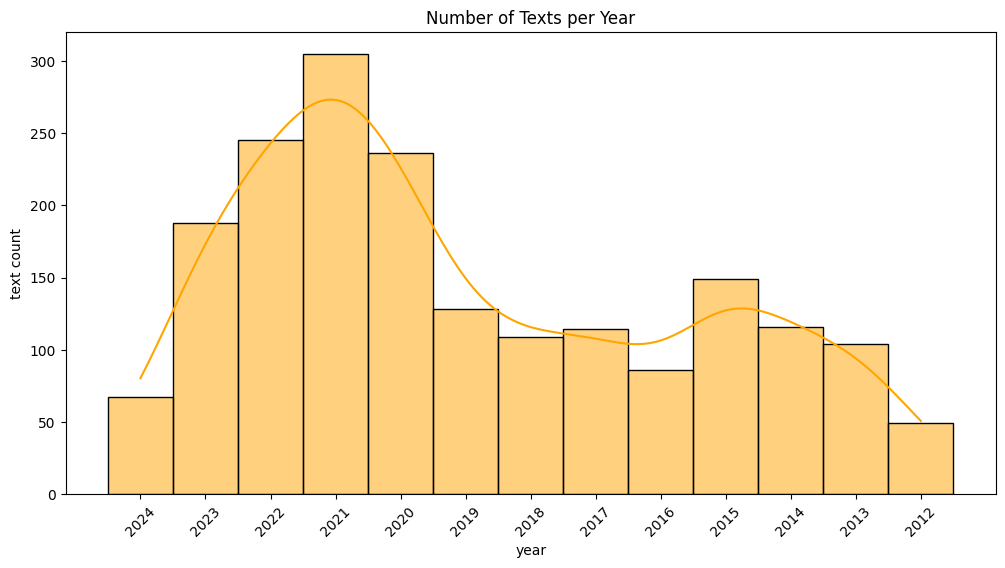

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(data=data_df, x='year', bins=range(2000, 2023), kde=True, legend=False, color='orange')
plt.xticks(rotation=45)
plt.title('Number of Texts per Year')
plt.ylabel('text count')
plt.show()


Now let's look at the most popular words per year.

In [15]:
data_df["processed_text_str"] = data_df["text"].apply(lambda x: ' '.join(x))
data_df.sample(2)

date                                              title  \
578   2017-07-03  Ομιλία στην προ ημερησίας διατάξεως συζήτηση σ...   
1888  2012-08-08  Σύσκεψη στο υπουργείο Οικονομικών | Ο Πρωθυπου...   

                                          original_text original_index  \
578   Κυρίες και κύριοι συνάδελφοι έχω την αίσθηση ό...            582   
1888  ΓΡΑΦΕΙΟ ΤΥΠΟΥ ΠΡΩΘΥΠΟΥΡΓΟΥ Αθήνα 8 Αυγούστου 2...           2023   

                                                   text  year  \
578   [πόρισμα, κοινοβουλευτικός, διενεργώ, εξέταση,...  2017   
1888  [μέγαρο, πέρας, συνάντησής, ακόλουθος, αληθινό...  2012   

                                     processed_text_str  
578   πόρισμα κοινοβουλευτικός διενεργώ εξέταση πρώη...  
1888  μέγαρο πέρας συνάντησής ακόλουθος αληθινός παλ...

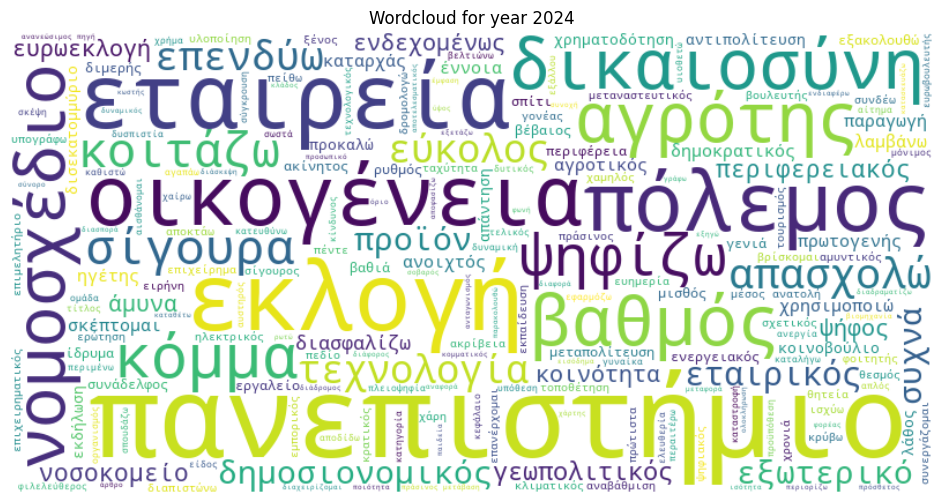

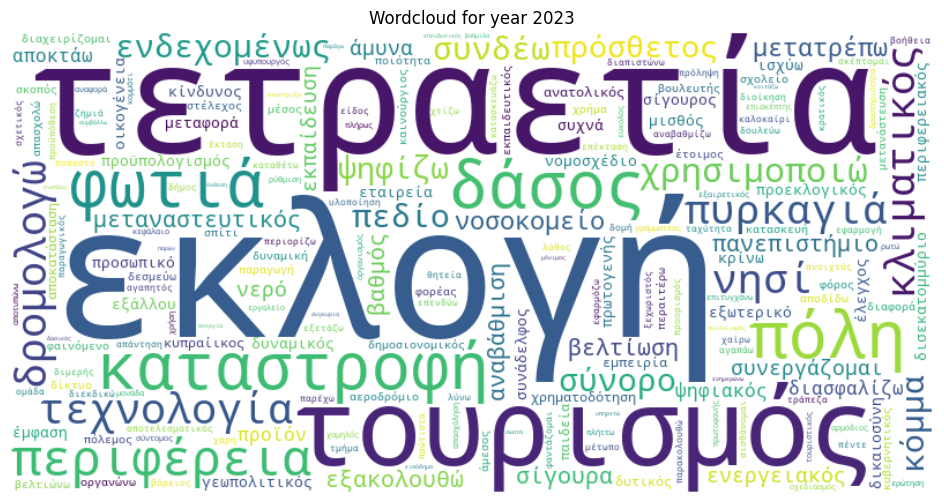

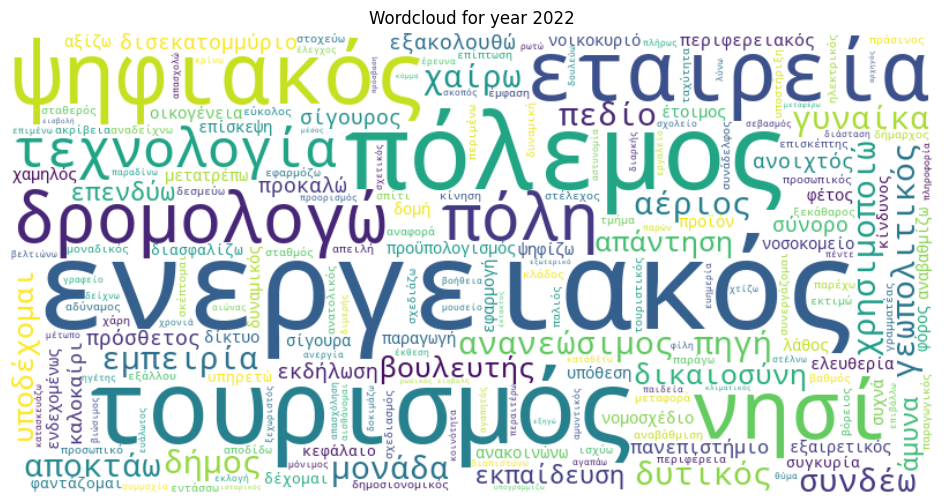

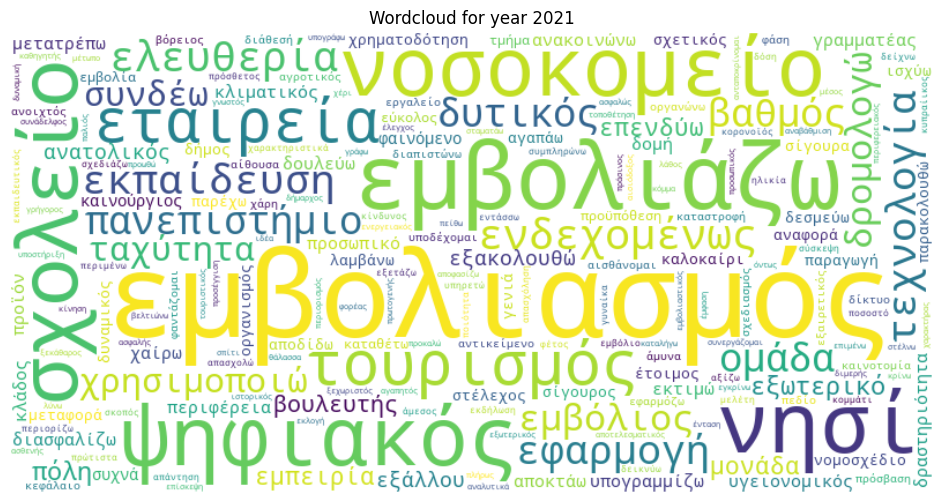

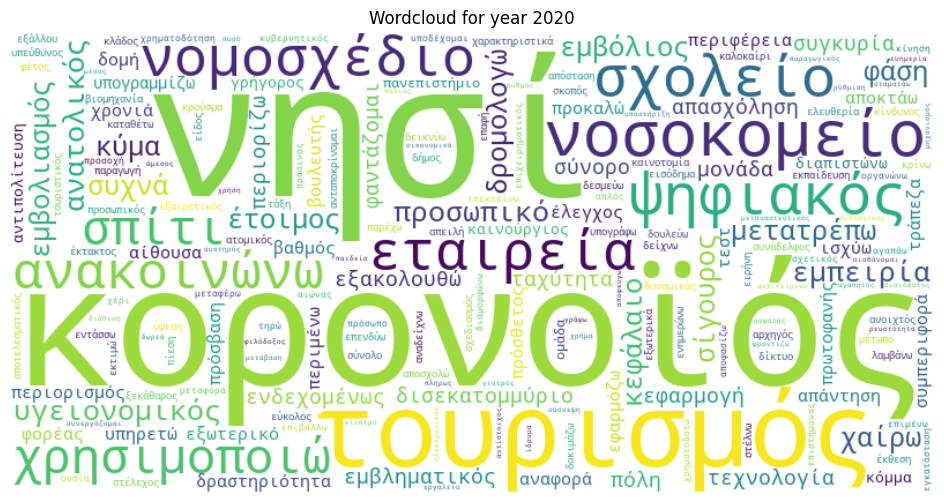

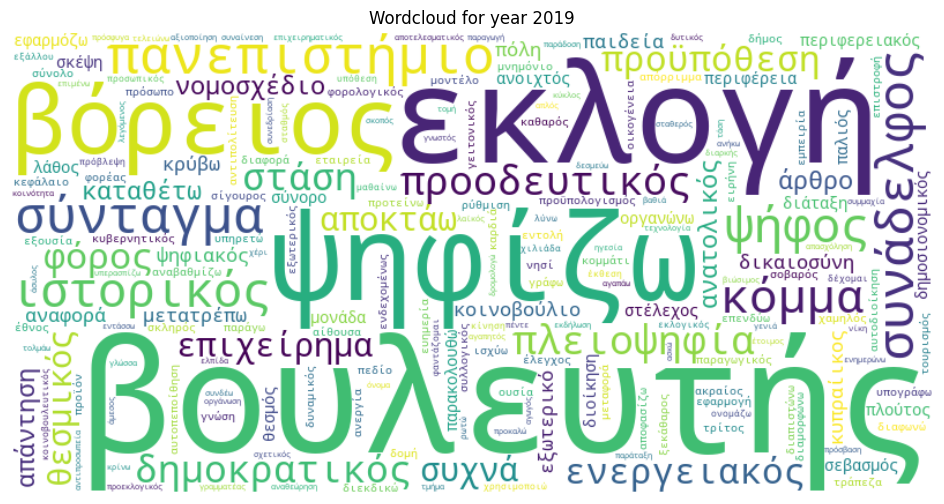

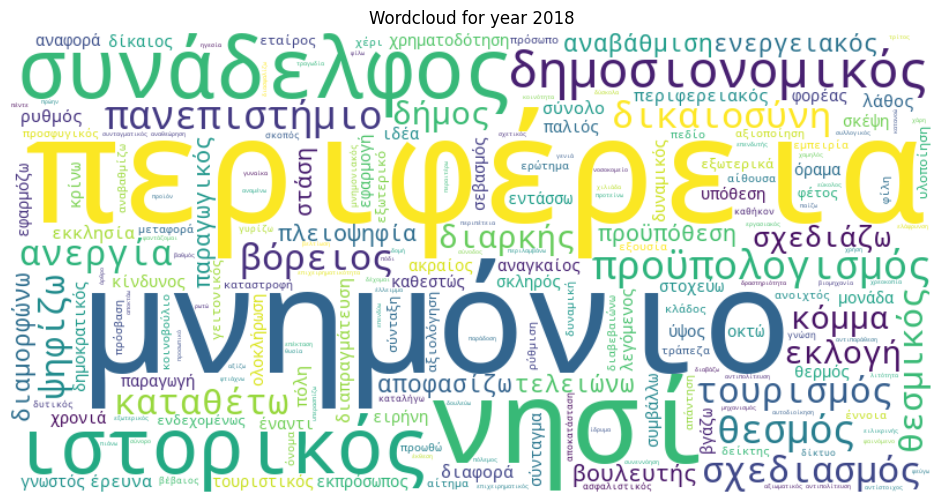

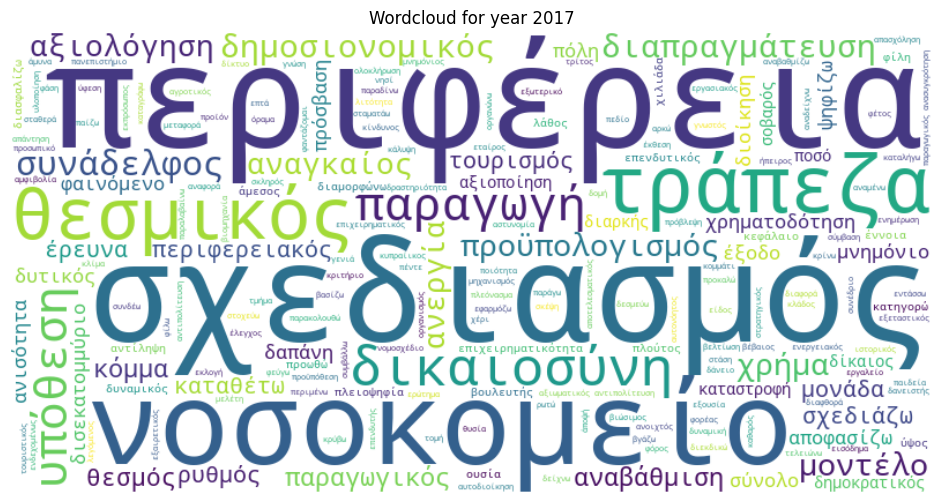

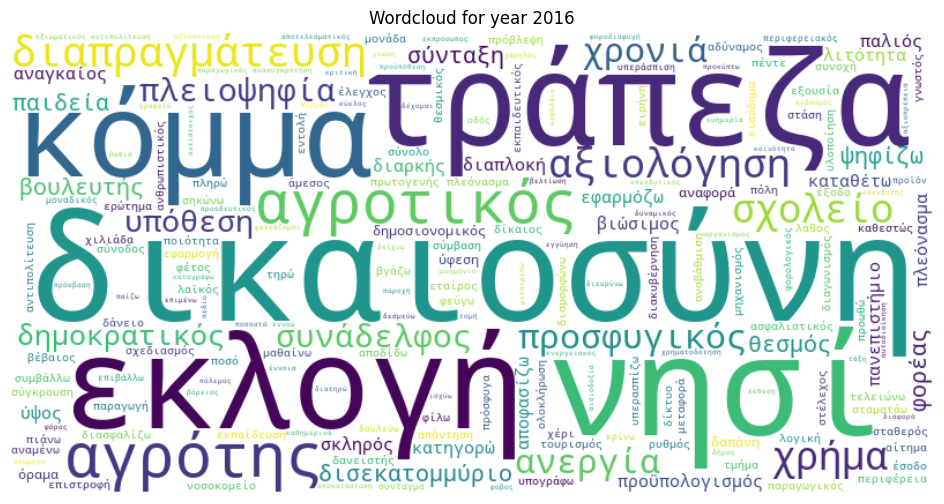

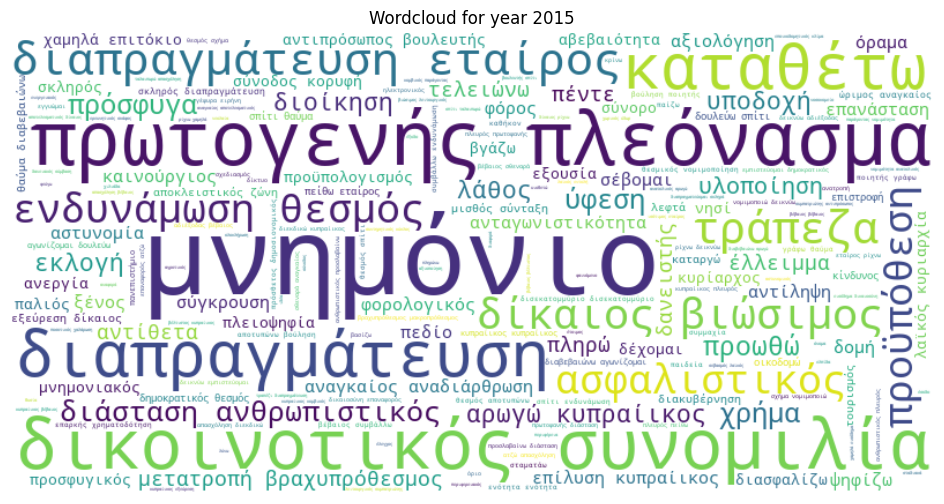

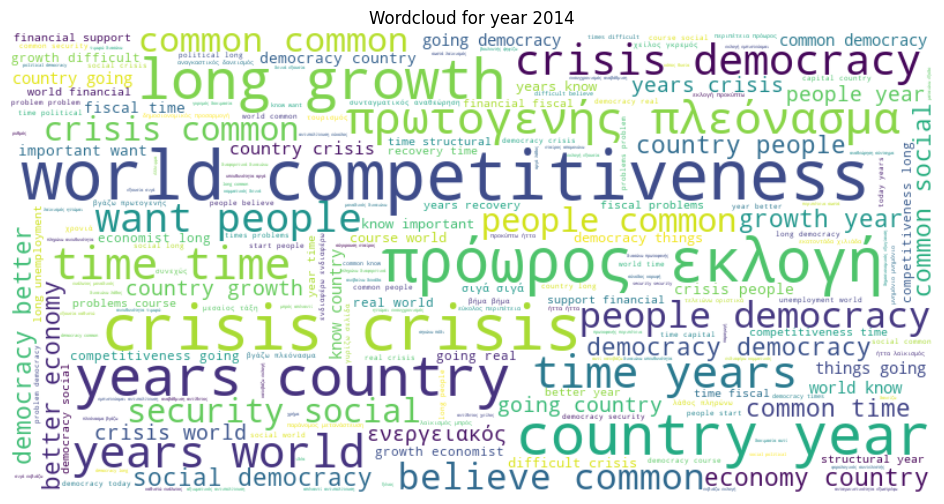

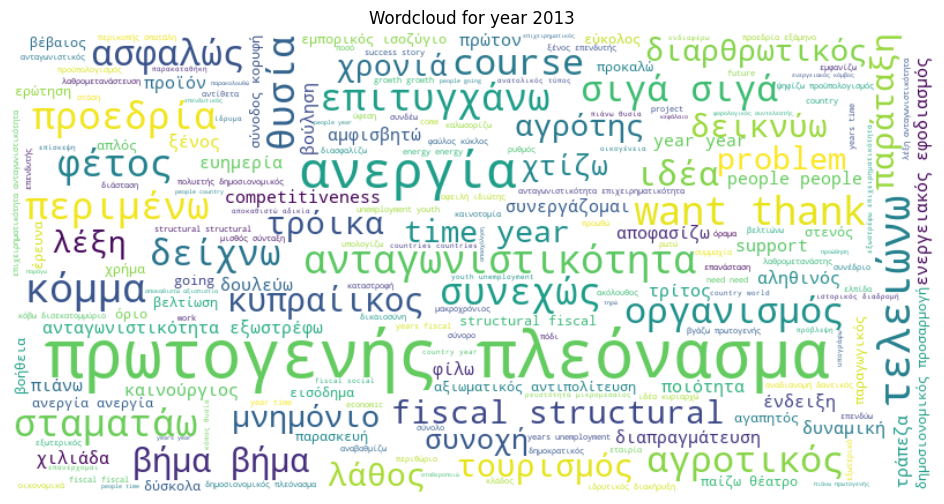

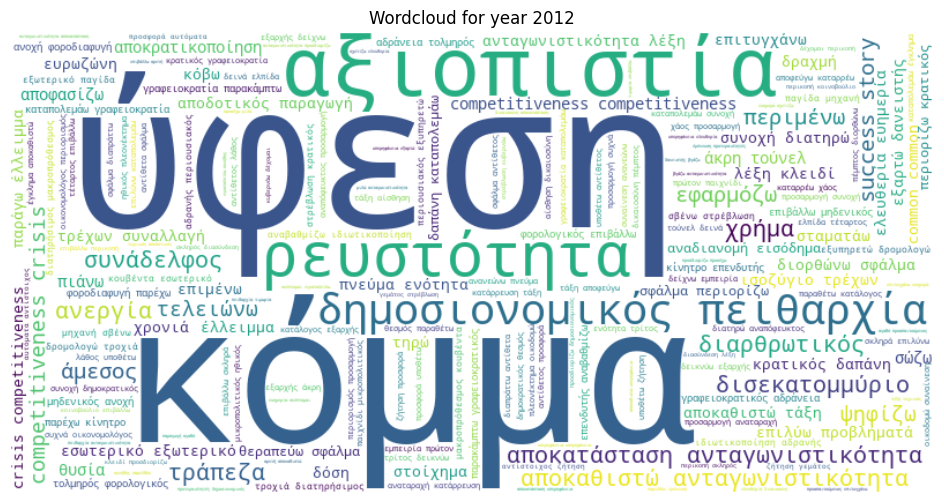

In [16]:
# create world clouds per year
from wordcloud import WordCloud

for year in data_df['year'].unique():
    text = ' '.join(data_df[data_df['year'] == year]['processed_text_str'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Wordcloud for year {year}')
    plt.show()

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

top_words = []

for year in data_df['year'].unique():
    text = data_df[data_df['year'] == year]['processed_text_str']
    cv = CountVectorizer(stop_words='english')
    X = cv.fit_transform(text)
    sum_words = X.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
    top_words.append((year, words_freq[:5]))
    
top_words

[('2024',
  [('πανεπιστήμιο', 111),
   ('εταιρεία', 70),
   ('εκλογή', 68),
   ('αγρότης', 57),
   ('πόλεμος', 53)]),
 ('2023',
  [('φωτιά', 185),
   ('τετραετία', 169),
   ('τουρισμός', 168),
   ('περιφέρεια', 167),
   ('εκλογή', 162)]),
 ('2022',
  [('ενεργειακός', 383),
   ('ψηφιακός', 269),
   ('τουρισμός', 228),
   ('πηγή', 208),
   ('πόλεμος', 203)]),
 ('2021',
  [('εμβολιασμός', 675),
   ('ψηφιακός', 390),
   ('εμβολιάζω', 378),
   ('υφυπουργός', 259),
   ('γραμματέας', 257)]),
 ('2020',
  [('τουρισμός', 249),
   ('νησί', 225),
   ('νοσοκομείο', 213),
   ('κορονοϊός', 204),
   ('ψηφιακός', 186)]),
 ('2019',
  [('βουλευτής', 194),
   ('εκλογή', 160),
   ('ψηφίζω', 120),
   ('πλειοψηφία', 116),
   ('βόρειος', 106)]),
 ('2018',
  [('μνημόνιο', 194),
   ('περιφέρεια', 173),
   ('παραγωγικός', 161),
   ('νησί', 158),
   ('δημοσιονομικός', 156)]),
 ('2017',
  [('παραγωγικός', 260),
   ('περιφέρεια', 246),
   ('σχεδιασμός', 166),
   ('παραγωγή', 166),
   ('μοντέλο', 165)]),
 ('2016',
 